In [1]:
from __future__ import print_function, division
from builtins import range

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

/Users/sai/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

In [5]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [10]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('Desktop/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [12]:
print('Loading in comments...')

train = pd.read_csv("Desktop/Kaggle_data/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values


Loading in comments...


In [13]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


In [14]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [15]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)


Shape of data tensor: (159571, 100)


In [16]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...


In [17]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [18]:
print('Building model...')

Building model...


In [19]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)

In [20]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 203s 2ms/step - loss: 0.0718 - acc: 0.9759 - val_loss: 0.0561 - val_acc: 0.9803
Epoch 2/5
127656/127656 [==============================] - 178s 1ms/step - loss: 0.0539 - acc: 0.9808 - val_loss: 0.0546 - val_acc: 0.9808
Epoch 3/5
127656/127656 [==============================] - 207s 2ms/step - loss: 0.0518 - acc: 0.9813 - val_loss: 0.0526 - val_acc: 0.9813
Epoch 4/5
127656/127656 [==============================] - 192s 2ms/step - loss: 0.0507 - acc: 0.9816 - val_loss: 0.0525 - val_acc: 0.9810
Epoch 5/5
127656/127656 [==============================] - 195s 2ms/step - loss: 0.0499 - acc: 0.9819 - val_loss: 0.0522 - val_acc: 0.9812


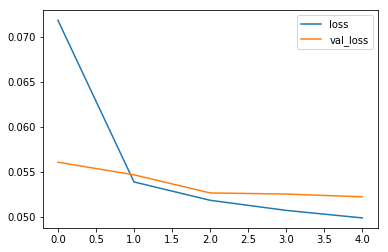

In [21]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

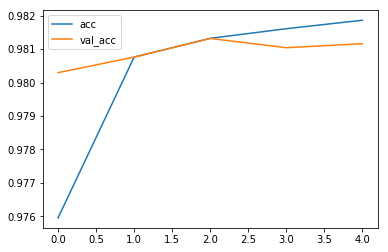

In [22]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [23]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9797058200901595
